# Particle initial positions

In the *processing* sub-package, a number tools have been provided to help with the creation of particle initial position files. These are described below.

## Release zones

To assist with connectivty studies, support for the creation of individual circular *release zones* has been added. In the *processing* sub-package, any number of particles can be placed in a release zone and their positions recorded in an initial positions file. Particles may be either *regularly* or *randomly* distributed within the zone. The former method is discontinuous, and only the latter guarantees that the specified number of particles will be added. If all particles that start out in a given *release zone* are given the same *group ID*, they can easily be tracked as a group. The following code illustrates the two ways in which particles can be scattered within a release zone.

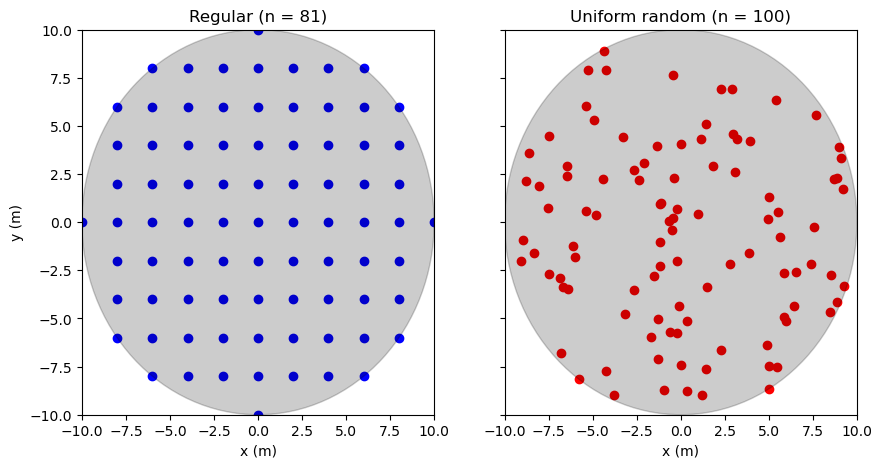

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

from pylag.processing.release_zone import create_release_zone


# Ensure inline plotting
%matplotlib inline

# Set particle properties
group_id = 1                 # Particle group ID
n_particles = 100            # Number of particles per release zone
radius = 10.0                # Release zone radius
centre = [0.0,0.0] # (x,y) coordinates of the release zone's centre
depth = 0.0                  # Depth of particles

# Create figure for plotting
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10,5))

# Regularly spaced particles (with random=False)
# ----------------------------------------------
release_zone_reg = create_release_zone(group_id, radius, centre, n_particles,
                                       depth, random=False)

eastings_reg, northings_reg, depth_reg = release_zone_reg.get_coords()
ax1.scatter(eastings_reg, northings_reg, c='b', marker='o')
ax1.add_patch(plt.Circle(centre, radius=radius, color='k', alpha=0.2))
ax1.set_title('Regular (n = {})'.format(
        release_zone_reg.get_number_of_particles()))
ax1.set_xlim(-radius,radius)
ax1.set_ylim(-radius,radius)
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')

# Randomly spaced particles (with random=True)
# ----------------------------------------------
release_zone_rand = create_release_zone(group_id, radius, centre, n_particles, 
                                        depth, random=True)
eastings_rand, northings_rand, depth_rand = release_zone_rand.get_coords()
ax2.scatter(eastings_rand, northings_rand, c='r', marker='o')
ax2.add_patch(plt.Circle(centre, radius=radius, color='k', alpha=0.2))
ax2.set_title('Uniform random (n = {})'.format(
        release_zone_rand.get_number_of_particles()))
ax2.set_xlim(-radius,radius)
ax2.set_ylim(-radius,radius)
ax2.set_xlabel('x (m)')

plt.show()

In applied work, it is often desirable to create a set of distinct release zones, each containing some number of particles. In addition to the creation of single release zones, the *processing* sub-package includes functionality that makes it possible to create sets of release zones. Two standard approaches are supported: a) the creation of a set of release zones along a specified cord, and b) the creation of a set of release zones along the edge of a polygon. The latter method has been introduced to make it possible to create sets of adjacent release zones that follow a coastline defined by a given polygon at some spefied fixed distance from the shore. Both approaches are described below.

### Release zones along a cord

A set of adjacent, non-overlapping release zones along a cord can be created in the following way.

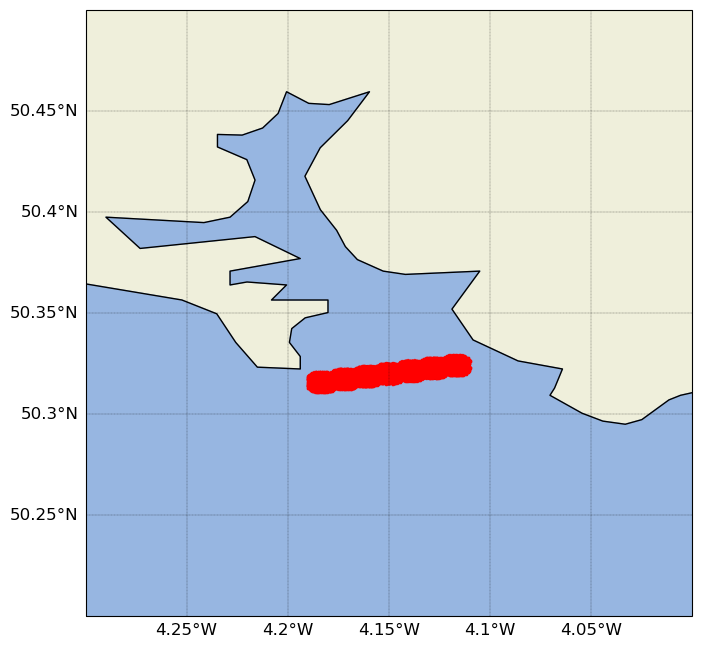

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from pylag.processing.coordinate import utm_from_lonlat, lonlat_from_utm
from pylag.processing.release_zone import create_release_zones_along_cord
from pylag.processing.plot import create_figure


def plot_release_zone_locations(release_zones, extents, epsg_code):
    """ Plot the location of particles in each release zone
    
    Parameters
    ----------
    release_zones : list
        List of release zones
    
    extents : list
        List of extents for the plot [xmin, xmax, ymin, ymax]

    epsg_code : str
        EPSG code for the coordinate system of the release zones

    """ 
    # Create figure
    font_size = 12
    projection = ccrs.PlateCarree()
    fig, ax = create_figure(figure_size=(20., 20.), font_size=font_size,
                            projection=projection)

    # Plot the location of particles in each release zone
    for zone in release_zones:
        lons, lats = lonlat_from_utm(zone.get_eastings(),
                                     zone.get_northings(),
                                     epsg_code=epsg_code)
        ax.scatter(lons, lats, zorder=2, transform=projection, marker='x', color='r')    

    # Tidy up the plot
    ax.set_extent(extents, projection)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                                edgecolor='face',
                                                facecolor=cfeature.COLORS['land']))
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                                                edgecolor='face',
                                                facecolor=cfeature.COLORS['water']))
    ax.coastlines(resolution='10m')
    gl = ax.gridlines(linewidth=0.2, draw_labels=True, linestyle='--', color='k')
    gl.xlabel_style = {'fontsize': font_size}
    gl.ylabel_style = {'fontsize': font_size}
    gl.top_labels=False
    gl.right_labels=False
    gl.bottom_labels=True
    gl.left_labels=True
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    
# Define some common properties for release zones
n_particles = 1000           # Number of particles per release zone
radius = 400.0               # Release zone radius (m)
depth = 0.0                  # Depth that particles will be released at

# Position vector of a point toward the LHS of the Tamar Estuary (lon, lat)
coords_lhs = np.array([-4.19, 50.315])

# Position vector of a point toward the RHS of the Tamar Estuary (lon, lat)
coords_rhs = np.array([-4.11, 50.325])

# Convert to UTM coordinates
epsg_code = '32630'
eastings, northings, _ = utm_from_lonlat([coords_lhs[0], coords_rhs[0]],
                                         [coords_lhs[1], coords_rhs[1]],
                                         epsg_code=epsg_code)

# Position vectors in UTM coordinates
coords_utm_lhs = np.array([eastings[0], northings[0]])
coords_utm_rhs = np.array([eastings[1], northings[1]])

# Create release zones
release_zones = create_release_zones_along_cord(coords_utm_lhs, coords_utm_rhs, radius=radius, 
        n_particles=n_particles, depth=depth, random=True)

# Plot
plot_release_zone_locations(release_zones, [-4.3, -4.0, 50.2, 50.5], epsg_code)

plt.show()

In the figure, each circle is populated with particles. In total, five release zones have been created. The circular shape of each release zone can be discerned from the position of particles.

### Release zones around an arbitrary polygon

A second practical case is the need to create release zones around an arbitrary shape such as an island or country. Given a single polygon that represents the shape in question, we can first create a buffer zone of a given size around the object. Using this buffer zone, we can create a set of adjacent, circular release zones around its perimeter, or some portion of it. To demonstrate this functionality, we use land boundary data from the Natural Earth dataset. We create a 10 km buffer zone around the Southwest UK coastline. Along this line, we create a set of release zones, each with a radius of 1 km and containing 100 particles. In full, the release zones extend 200 km around the coast in a clockwise direction.

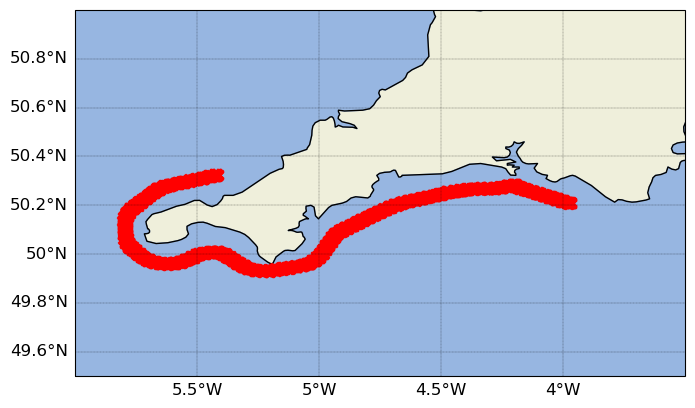

In [7]:
import os
import subprocess
import zipfile
import geopandas as gpd
from shapely.geometry import Point

from pylag.processing.release_zone import create_release_zones_around_shape_section


# We will use 50 m resolution land data from the Natural Earth website
land_product_name = "ne_50m_land"
land_data_dir = f"./{land_product_name}"
land_data_file_name = f"{land_data_dir}/{land_product_name}.shp"

# Only download the data if it hasn't been downloaded already
if not os.path.isfile(f"{land_data_file_name}"):

    # Download the data?
    zip_file = f"{land_product_name}.zip"
    if not os.path.isfile(f"./{zip_file}"):
        url = (f"https://www.naturalearthdata.com/http/"
               f"/www.naturalearthdata.com/download/50m/"
               f"physical/{zip_file}")
        download = subprocess.run(["wget", f"{url}"],
                                  capture_output=True,
                                  encoding='utf-8')
        download.check_returncode()

    # Unzip the data
    with zipfile.ZipFile(f"./{zip_file}", "r") as zip_ref:
        zip_ref.extractall(land_data_dir)


# Define characteristics of the release zones
# -------------------------------------------

# Location where we want to start creating release zones
start_loc = Point(-4., 50.3)

# Target length of path along which to create release zones (200 km)
target_length = 2.0e5

# Radius of release zones (1000 m)
radius = 1000.0

# Number of particles to release per release zone
n_particles = 100

# Read in the data
# ----------------
gdf = gpd.read_file(land_data_file_name)

# Extract data for Ireland and UK
gdf = gdf.cx[-10.0:0.0, 50.0:60.0]

# Determine the closest polygon to the start location
# ---------------------------------------------------

# Convert shapefile to UTM coordinates, EPSG:32630
utm_epsg_code = '32630'
gdf = gdf.to_crs(epsg=utm_epsg_code)

# Create a copy of the data
gdf_buffered = gdf.copy()

# Add 10,000 m buffer
buffer_size = 10.e4
gdf_buffered['geometry'] = gdf_buffered.buffer(buffer_size)

# Find closest polygon
closest_polygon = gdf_buffered.distance(start_loc).idxmin()

# Convert back to lon/lat
gdf = gdf.to_crs(epsg=4326)
gdf_buffered = gdf_buffered.to_crs(epsg=4326)

# Extract the closest polygon
poly = gdf_buffered.loc[closest_polygon, 'geometry']

# Create release zones
# --------------------
release_zones = create_release_zones_around_shape_section(poly,
                                                          start_loc,
                                                          target_length=target_length,
                                                          release_zone_radius=radius,
                                                          n_particles=n_particles)

# Plot the release zones
# ----------------------
plot_release_zone_locations(release_zones, [-6.0, -3.5, 49.5, 51.],
                            utm_epsg_code)

## Creating initial position files

Two methods have been included to assist with the writing of initial position files. The first will create a correctly formatted initial positions file for a single group of particles. The second, which is designed to be used with data for multiple particle groups, will create an initial positions file when given a list of release zone objects.

Below, we create a temporary directory called `example_initial_position_files`, and create within it two initial positions files: one for a single group of particles and the second for multiple groups of particles.

In [4]:
import os

from pylag.processing.input import create_initial_positions_file_single_group
from pylag.processing.input import create_initial_positions_file_multi_group

# Create input sub-directory
test_dir = './example_initial_position_files'
try:
    os.makedirs(test_dir)
except FileExistsError:
    pass

# Single group
# ------------

# Output filename
file_name = '{}/initial_positions_single_group.dat'.format(test_dir)

# Write test data to file
n_particles = 2
group_id = 1 
lons = np.array([-4.16, -4.5])
lats = np.array([50.25, 50.26])
depths = np.array([0.0, 0.0])
create_initial_positions_file_single_group(file_name,
                                           n_particles,
                                           group_id,
                                           lons,
                                           lats,
                                           depths)

# Multi group
# -----------

# Output filename
file_name = '{}/initial_positions_multi_group.dat'.format(test_dir)

# Here, we reuse the release zone object created previously
create_initial_positions_file_multi_group(file_name, release_zones)